# Assignment 1-2: Support Vector Machine

## Multiclass Support Vector Machine exercise


In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient


## CIFAR-10 Data Loading and Preprocessing

In [1]:
!pip install scikit-learn

In [40]:
from data_utils import load_pickle,load_CIFAR10,load_CIFAR_batch
from download import _print_download_progress,maybe_download_and_extract


import numpy as np
import matplotlib.pyplot as plt
import time

In [18]:
# Load the raw CIFAR-10 data.
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"
maybe_download_and_extract(url,download_dir)

# %%
cifar10_dir = '/content/data/CIFAR-10/cifar-10-batches-py'


Data has apparently already been downloaded and unpacked.


In [27]:
X_train,y_train,X_test,y_test = load_CIFAR10(cifar10_dir)


In [28]:
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)

Train data shape:  (50000, 32, 32, 3)
Train labels shape:  (50000,)


In [29]:

# Set the number of samples for each set
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

In [30]:
# Our validation set will be num_validation points from the original training set.
X_val = X_train[num_training:num_training + num_validation]
y_val = y_train[num_training:num_training + num_validation]

# Our training set will be the first num_train points from the original training set.
X_train = X_train[:num_training]
y_train = y_train[:num_training]

# We will also make a development set, which is a small subset of the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our test set.
X_test = X_test[:num_test]
y_test = y_test[:num_test]

# Print shapes to verify the splits
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Development data shape: ', X_dev.shape)
print('Development labels shape: ', y_dev.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Development data shape:  (500, 32, 32, 3)
Development labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [31]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('Development data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
Development data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


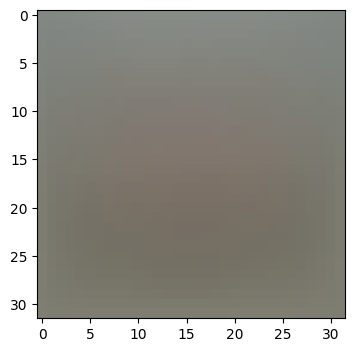

In [34]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

## SVM Classifier

You need to complete `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function.

In [35]:
from builtins import range
import numpy as np
from random import shuffle
from past.builtins import xrange

def svm_loss_naive(W, X, y, reg):

    dW = np.zeros(W.shape)

    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0

    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1
            if margin > 0:
                loss += margin
                dW[:, j] += X[i]
                dW[:, y[i]] -= X[i]

    loss /= num_train
    loss += reg * np.sum(W * W)

    dW /= num_train
    dW += 2 * reg * W

    return loss, dW



In [36]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.288473


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [37]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 29.191349 analytic: 29.191349, relative error: 6.357104e-12
numerical: 10.209957 analytic: 10.209957, relative error: 2.832170e-11
numerical: -1.215051 analytic: -1.215051, relative error: 2.688559e-10
numerical: -5.795541 analytic: -5.795541, relative error: 5.562482e-11
numerical: -13.091460 analytic: -13.114688, relative error: 8.863514e-04
numerical: 29.382702 analytic: 29.382702, relative error: 7.541749e-12
numerical: -1.755797 analytic: -1.755797, relative error: 1.755237e-10
numerical: 32.615205 analytic: 32.615205, relative error: 3.625129e-13
numerical: 0.260218 analytic: 0.260218, relative error: 8.769583e-10
numerical: -22.556951 analytic: -22.556951, relative error: 5.090785e-12
numerical: 1.625470 analytic: 1.658575, relative error: 1.008040e-02
numerical: -9.152016 analytic: -9.152016, relative error: 2.950529e-12
numerical: -29.370870 analytic: -29.370870, relative error: 9.943131e-12
numerical: -18.529368 analytic: -18.529368, relative error: 1.331978e-12
nu

Complete the implementation of svm_loss_vectorized, and compute the gradient of the loss function in a vectorized way.

In [41]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape)

    num_train = X.shape[0]
    scores = X.dot(W)
    correct_class_scores = scores[np.arange(num_train), y]
    margins = np.maximum(0, scores - correct_class_scores[:, np.newaxis] + 1)
    margins[np.arange(num_train), y] = 0
    loss = np.sum(margins) / num_train
    loss += reg * np.sum(W * W)

    binary = margins > 0
    binary = binary.astype(int)
    incorrect_counts = np.sum(binary, axis=1)
    binary[np.arange(num_train), y] = -incorrect_counts
    dW = X.T.dot(binary) / num_train
    dW += 2 * reg * W

    return loss, dW


In [42]:
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.110247s
Vectorized loss and gradient: computed in 0.012631s
difference: 0.000000


### Discussion